# Diffusion Part 2
Now that we have walked through the diffusion process, we can abstract everything away into some classes and folders. We have stored our U-Net in a python file `unet.py`, the data loading into a `utils.py` files, and finally, the main diffusion algorthim in the `ddpm.py` file. From here on, we call the `DDPM` class the `scheduler`...because that's essentially what it does.

So now we can simply import all these classes and run the diffusion process in a few lines of code.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

### Get the data

In [2]:
import sys
sys.path.append('..')
from diffusion_models.utils import *
from diffusion_models.unet import UNetSmol
from diffusion_models.ddpm import DDPM

DATA_PATH = '../data/'
train_loader, test_loader = get_mnist(32, DATA_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Get the model and optimizer

In [51]:
unet = UNetSmol(input_channels=1,
                output_channels=1,
                block_channels=[32,64,128])
optimizer = optim.AdamW(unet.parameters(), lr=0.001)

### Define the scheduler

In [52]:
scheduler = DDPM(
    model = unet,
    optimizer = optimizer,
    T = 150,
    start = 0.0001,
    end = 0.02,
)

### Train for a few epochs

In [53]:
losses = scheduler.train(train_loader, epochs=20)

Training: 100%|██████████| 1875/1875 [11:02<00:00,  2.83it/s]


Epoch [1/20], Loss: 0.1088


Training: 100%|██████████| 1875/1875 [09:59<00:00,  3.13it/s]


Epoch [2/20], Loss: 0.0819


Training: 100%|██████████| 1875/1875 [10:02<00:00,  3.11it/s]


Epoch [3/20], Loss: 0.0753


Training: 100%|██████████| 1875/1875 [09:58<00:00,  3.13it/s]


Epoch [4/20], Loss: 0.0724


Training: 100%|██████████| 1875/1875 [10:02<00:00,  3.11it/s]


Epoch [5/20], Loss: 0.0697


Training: 100%|██████████| 1875/1875 [09:51<00:00,  3.17it/s]


Epoch [6/20], Loss: 0.0684


Training: 100%|██████████| 1875/1875 [09:30<00:00,  3.28it/s]


Epoch [7/20], Loss: 0.0673


Training: 100%|██████████| 1875/1875 [09:21<00:00,  3.34it/s]


Epoch [8/20], Loss: 0.0659


Training: 100%|██████████| 1875/1875 [09:29<00:00,  3.29it/s]


Epoch [9/20], Loss: 0.0652


Training: 100%|██████████| 1875/1875 [09:27<00:00,  3.30it/s]


Epoch [10/20], Loss: 0.0650


Training: 100%|██████████| 1875/1875 [09:36<00:00,  3.25it/s]


Epoch [11/20], Loss: 0.0641


Training: 100%|██████████| 1875/1875 [09:48<00:00,  3.18it/s]


Epoch [12/20], Loss: 0.0634


Training: 100%|██████████| 1875/1875 [09:41<00:00,  3.22it/s]


Epoch [13/20], Loss: 0.0634


Training:   9%|▉         | 176/1875 [00:55<08:59,  3.15it/s]


KeyboardInterrupt: 

### Sample from the model and visualize the results

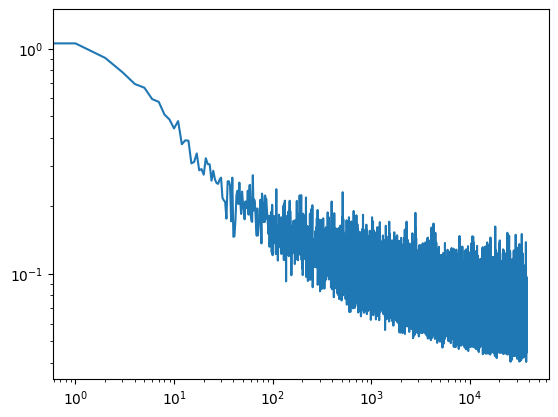

In [54]:


plt.loglog(losses)
plt.show()

In [84]:
x_ts = scheduler.sample(9, 10)
x_ts = np.array(x_ts)

100%|██████████| 150/150 [00:01<00:00, 77.35it/s]


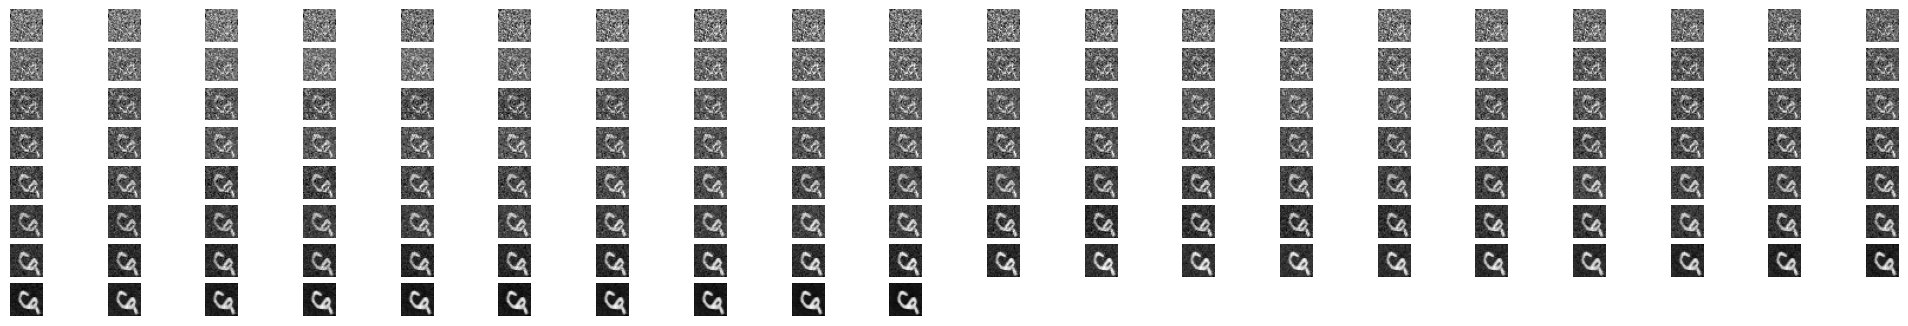

In [85]:
plt.figure(figsize=(25,5))

single = x_ts[:, 0, :, :]

for t in range(scheduler.T):
    img = single[t].squeeze()
    ax = plt.subplot(10, 20, t + 1)
    ax.axis("off")
    plt.imshow(img, cmap="gray")

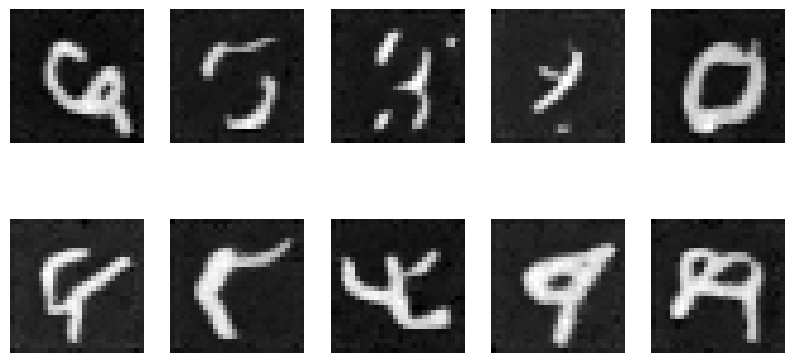

In [86]:
import matplotlib.pyplot as plt

example = x_ts[-1]

plt.figure(figsize=(10, 5))
for i in range(10):
    img = example[i][0]
    ax = plt.subplot(2, 5, i + 1)
    ax.axis('off')
    plt.imshow(img, cmap='gray')

Obviously the results are not great, because we only trained a very small model on a few epochs, but feel free to adjust the hyperparameters however you want. You'll notice that as you increase the number of epochs and the size of the model, you'll get significantly better results.

We built a lot of this from scratch. Surely someone has done this process for us already? Yes, they have! The `diffusion` library is a PyTorch library that implements the diffusion process and provides a lot of utilities to make the process easier.